In [1]:
from pathlib import Path
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from chromadb import PersistentClient
from tqdm import tqdm
from litellm import completion
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [2]:
load_dotenv(override=True)

MODEL = "gpt-4.1-mini"

DB_NAME = "preprocessed_db"
collection_name = "docs"
embedding_model = "text-embedding-3-large"
KNOWLEDGE_BASE_PATH = Path("transformed_data_llm_cleaned")
AVERAGE_CHUNK_SIZE = 500

openai = OpenAI()

In [3]:
# Inspired by LangChain's Document - let's have something similar

class Result(BaseModel):
    page_content: str
    metadata: dict

In [4]:
# A class to perfectly represent a chunk

class Chunk(BaseModel):
    headline: str = Field(description="A brief heading for this chunk, typically a few words, that is most likely to be surfaced in a query")
    summary: str = Field(description="A few sentences summarizing the content of this chunk to answer common questions")
    original_text: str = Field(description="The original text of this chunk from the provided document, exactly as is, not changed in any way")

    def as_result(self, document):
        metadata = {"source": document["source"], "type": document["type"]}
        return Result(page_content=self.headline + "\n\n" + self.summary + "\n\n" + self.original_text,metadata=metadata)


class Chunks(BaseModel):
    chunks: list[Chunk]

In [5]:
def fetch_documents():
    """Loads all markdown files from the transformed_data_llm_cleaned folder"""

    documents = []

    for file in KNOWLEDGE_BASE_PATH.rglob("*.md"):
        with open(file, "r", encoding="utf-8") as f:
            documents.append({
                "type": "Knowledge base for Masters in Data Science at FAU",           # any label you want
                "source": file.as_posix(),
                "text": f.read()
            })

    print(f"Loaded {len(documents)} documents from {KNOWLEDGE_BASE_PATH}")
    return documents

In [6]:
documents = fetch_documents()

Loaded 7 documents from transformed_data_llm_cleaned


In [7]:
def make_prompt(document):
    how_many = (len(document["text"]) // AVERAGE_CHUNK_SIZE) + 1
    return f"""
You take a document and you split the document into overlapping chunks for a Knowledge Base.

The document contains public information about the Department of Data Science at FAU.
The document is of type: {document["type"]}
The document has been retrieved from: {document["source"]}
The content was collected from public websites and/or public PDFs and converted to markdown.

A chatbot will use these chunks to answer questions about the department, its programs, courses,
and related information.

Your task:
- Divide the document into coherent chunks that are useful for retrieval.
- Make sure the **entire** document is covered in the chunks; do not leave anything out.
- This document will probably be split into about {how_many} chunks, but you may use more or fewer as appropriate.
- There should be overlap between neighboring chunks (typically ~25% overlap or about 50 words)
  so that important context appears in multiple chunks.
- Preserve important markdown structure such as headings, bullet lists, tables, and links inside each chunk.
- Do **not** add new facts; only use the information that appears in the document.

For each chunk, provide:
1. A short headline for the chunk.
2. A brief summary of the chunk.
3. The original text of the chunk (from the document, with markdown preserved).

Together, your chunks should represent the entire document with appropriate overlap.

Here is the document in markdown:

{document["text"]}

Respond with the chunks.
"""

In [8]:
def make_messages(document):
    return [
        {"role": "user", "content": make_prompt(document)},
    ]

In [9]:
def process_document(document):
    messages = make_messages(document)
    response = completion(model=MODEL, messages=messages, response_format=Chunks)
    reply = response.choices[0].message.content
    doc_as_chunks = Chunks.model_validate_json(reply).chunks
    return [chunk.as_result(document) for chunk in doc_as_chunks]

In [10]:
def create_chunks(documents):
    chunks = []
    for doc in tqdm(documents):
        chunks.extend(process_document(doc))
    return chunks

In [11]:
chunks = create_chunks(documents)

100%|██████████| 7/7 [19:50<00:00, 170.04s/it]


In [12]:
print(len(chunks))

140


In [13]:
def create_embeddings(chunks):
    chroma = PersistentClient(path=DB_NAME)
    if collection_name in [c.name for c in chroma.list_collections()]:
        chroma.delete_collection(collection_name)

    texts = [chunk.page_content for chunk in chunks]
    emb = openai.embeddings.create(model=embedding_model, input=texts).data
    vectors = [e.embedding for e in emb]

    collection = chroma.get_or_create_collection(collection_name)

    ids = [str(i) for i in range(len(chunks))]
    metas = [chunk.metadata for chunk in chunks]

    collection.add(ids=ids, embeddings=vectors, documents=texts, metadatas=metas)
    print(f"Vectorstore created with {collection.count()} documents")

    return collection

In [14]:
collection = create_embeddings(chunks)

Vectorstore created with 140 documents


In [15]:
class RankOrder(BaseModel):
    order: list[int] = Field(
        description="The order of relevance of chunks, from most relevant to least relevant, by chunk id number"
    )

In [16]:
def rerank(question, chunks):
    system_prompt = """
You are a document re-ranker.
You are provided with a question and a list of relevant chunks of text from a query of a knowledge base.
The chunks are provided in the order they were retrieved; this should be approximately ordered by relevance, but you may be able to improve on that.
You must rank order the provided chunks by relevance to the question, with the most relevant chunk first.
Reply only with the list of ranked chunk ids, nothing else. Include all the chunk ids you are provided with, reranked.
"""
    user_prompt = f"The user has asked the following question:\n\n{question}\n\nOrder all the chunks of text by relevance to the question, from most relevant to least relevant. Include all the chunk ids you are provided with, reranked.\n\n"
    user_prompt += "Here are the chunks:\n\n"
    for index, chunk in enumerate(chunks):
        user_prompt += f"# CHUNK ID: {index + 1}:\n\n{chunk.page_content}\n\n"
    user_prompt += "Reply only with the list of ranked chunk ids, nothing else."
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    response = completion(model=MODEL, messages=messages, response_format=RankOrder)
    reply = response.choices[0].message.content
    order = RankOrder.model_validate_json(reply).order
    return [chunks[i - 1] for i in order]

In [17]:
RETRIEVAL_K = 10

def fetch_context_unranked(question):
    query = openai.embeddings.create(model=embedding_model, input=[question]).data[0].embedding
    results = collection.query(query_embeddings=[query], n_results=RETRIEVAL_K)
    chunks = []
    for result in zip(results["documents"][0], results["metadatas"][0]):
        chunks.append(Result(page_content=result[0], metadata=result[1]))
    return chunks

In [18]:
question = "which language Bsc Data Science?"
chunks = fetch_context_unranked(question)

In [19]:
reranked = rerank(question, chunks)

In [20]:
def fetch_context(question):
    chunks = fetch_context_unranked(question)
    return rerank(question, chunks)

In [21]:
SYSTEM_PROMPT = """
You are a knowledgeable, friendly assistant representing the study advisory for the Department of Data Science at FAU Erlangen.
You are chatting with a user about the Department of Data Science and its study programs.
Your answer will be evaluated for accuracy, relevance, and completeness, so make sure it only answers the question and fully answers it.
If you don’t know the answer, say so.
For context, here are specific extracts from the Knowledge Base that might be directly relevant to the user’s question:
{context}

With this context, please answer the user’s question. Be accurate, relevant, and complete.
"""


In [22]:
# In the context, include the source of the chunk

def make_rag_messages(question, history, chunks):
    context = "\n\n".join(f"Extract from {chunk.metadata['source']}:\n{chunk.page_content}" for chunk in chunks)
    system_prompt = SYSTEM_PROMPT.format(context=context)
    return [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": question}]

In [23]:
def rewrite_query(question, history=[]):
    """Rewrite the user's question to be a more specific question that is more likely to surface relevant content in the Knowledge Base."""
    message = f"""
You are in a conversation with a user, answering questions about the study advisory for the Department of Data Science at FAU Erlangen.
You are about to look up information in a Knowledge Base to answer the user's question.

This is the history of your conversation so far with the user:
{history}

And this is the user's current question:
{question}

Respond only with a single, refined question that you will use to search the Knowledge Base.
It should be a VERY short, specific question most likely to surface content relevant to the Data Science study programs at FAU Erlangen.
Focus on concrete details (e.g., admissions, course structure, requirements, deadlines, modules).
Don't mention FAU Erlangen unless it's necessary to clarify context.
IMPORTANT: Respond ONLY with the knowledge base search query, nothing else.
"""
    response = completion(model=MODEL, messages=[{"role": "system", "content": message}])
    return response.choices[0].message.content

In [24]:
rewrite_query("which language Bsc Data Science?", [])

'language of instruction BSc Data Science program'

In [25]:
def answer_question(question: str, history: list[dict] = []) -> tuple[str, list]:
    """
    Answer a question using RAG and return the answer and the retrieved context
    """
    query = rewrite_query(question, history)
    chunks = fetch_context(query)
    messages = make_rag_messages(question, history, chunks)
    response = completion(model=MODEL, messages=messages)
    return response.choices[0].message.content

In [26]:
answer_question("which language Bsc Data Science?", [])

'The Bachelor of Science (B.Sc.) in Data Science at FAU Erlangen is taught completely in German.'

In [27]:
questions = [
    "Is admission to the B.Sc. Data Science program at FAU restricted?",
    "What is the teaching language for the Data Science bachelor's program at FAU?",
    "How long is the standard duration of the B.Sc. Data Science program?",
    "Is there support for students at the start of the program?",
    "What subjects do students learn in the first year?",
    "Can students go abroad during the bachelor’s degree?",
    "What type of student is the Data Science program suitable for?",
    "What specialization areas are available in the later semesters?",
    "What career prospects are available after completing the degree?",
    "How do international applicants apply for the Data Science program?"
]

In [28]:
answers = []
for question in questions:
    answers.append(answer_question(question, []))


In [29]:
answers

['No, admission to the B.Sc. Data Science program at FAU Erlangen is not restricted. There are no admissions restrictions for the first semester of this program.',
 "The teaching language for the Data Science bachelor's program at FAU Erlangen is completely German.",
 'The standard duration of the B.Sc. Data Science program at FAU Erlangen is six semesters.',
 "Yes, for the Data Science Bachelor’s program at FAU Erlangen, there is support at the start of the program. Before the first semester begins, a voluntary preliminary course is offered to help students get started in their studies. Additionally, there is an orientation week during the first semester (usually in October) designed for all first-year students in related programs such as Mathematics, Data Science, and Physics. Participation in the orientation week is optional but strongly recommended. \n\nFor more details, the orientation week information can be found here: https://mp.fsi.fau.de/index.php/ersti-infos/orientierungswoc

In [30]:
Actual_answers = [
    "No, admission for the first semester is not restricted. There are no admission restrictions.",
    "The teaching language is completely German, and very good German language skills are required for enrollment.",
    "The standard duration of the program is 6 semesters.",
    "Yes. A voluntary preliminary course and an orientation week are offered to help new students get started.",
    "In the first year, students learn analysis, linear algebra, algorithms and data structures, modeling, and programming.",
    "Yes. A semester abroad (e.g., Erasmus) is possible, typically in the 2nd or 3rd year of study.",
    "It is suitable for students who enjoy mathematics, programming, data analysis, analytical thinking, and digital technologies.",
    "Specializations include Statistical Data Analysis, Data-Oriented Optimization, Mathematical Theory of Data Science, Knowledge Representation, Artificial Intelligence, Simulation and Numerics, etc.",
    "Graduates can work in technology, consulting, finance, logistics, energy, and biomedical research. Demand for data scientists in Germany is high.",
    "International applicants apply via campo.fau.de before the deadline and must provide proof of German language skills."
]

In [31]:
def grade_answer(question: str, rag_answer: str, gold_answer: str):
    """
    Use an LLM to grade a RAG answer against the gold answer.
    Returns (score:int 1-5, justification:str).
    """
    system_prompt = """
You are a strict evaluator for a Q&A system.

You will be given:
- a question
- a gold/reference answer
- a RAG system's answer

Rate the RAG answer on a scale from 1 to 5, where:
1 = Excellent: fully correct, matches the gold answer in meaning, no important errors or omissions.
2 = Good: mostly correct, only minor omissions or wording differences.
3 = Fair: partially correct, but missing some important points or slightly misleading.
4 = Poor: contains major errors, important missing information, or noticeable hallucinations.
5 = Very poor: largely incorrect, off-topic, or contradicts the gold answer.

FOCUS on factual correctness and alignment with the gold answer.
Do NOT penalize minor stylistic differences.

Respond ONLY in valid JSON with this structure:
{"score": <integer 1-5>, "justification": "<short explanation>"}
    """.strip()

    user_prompt = f"""
Question:
{question}

Gold/reference answer:
{gold_answer}

RAG answer:
{rag_answer}

Now rate the RAG answer.
    """.strip()

    resp = openai.chat.completions.create(
        model="gpt-4.1-mini",      # or any model you prefer
        temperature=0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )

    content = resp.choices[0].message.content
    data = json.loads(content)   # parse the JSON
    return int(data["score"]), data["justification"]

In [32]:
import json

In [33]:
scores = []
justifications = []

for q, rag, gold in zip(questions, answers, Actual_answers):
    score, reason = grade_answer(q, rag, gold)
    scores.append(score)
    justifications.append(reason)

# Inspect results
for i, (q, s, j) in enumerate(zip(questions, scores, justifications), start=1):
    print(f"Q{i}: {q}")
    print(f"  Score: {s} (1 = best, 5 = worst)")
    print(f"  Reason: {j}\n")

print("Average score:", sum(scores) / len(scores))

Q1: Is admission to the B.Sc. Data Science program at FAU restricted?
  Score: 1 (1 = best, 5 = worst)
  Reason: The RAG answer fully matches the gold answer in meaning, confirming that admission is not restricted and specifying it applies to the first semester, with no important errors or omissions.

Q2: What is the teaching language for the Data Science bachelor's program at FAU?
  Score: 2 (1 = best, 5 = worst)
  Reason: The RAG answer correctly states that the teaching language is completely German, matching the gold answer. However, it omits the important detail that very good German language skills are required for enrollment.

Q3: How long is the standard duration of the B.Sc. Data Science program?
  Score: 1 (1 = best, 5 = worst)
  Reason: The RAG answer correctly states the standard duration as six semesters, matching the gold answer in meaning with no important errors or omissions.

Q4: Is there support for students at the start of the program?
  Score: 1 (1 = best, 5 = worst

In [34]:
scores

[1, 2, 1, 1, 1, 1, 2, 1, 2, 2]

In [35]:
questions = [
    # --- Block 1: B.Sc. Data Science (Programme FAQ) ---
    "What degree do you obtain when you complete the Data Science program at FAU?",
    "Are there admission restrictions for the 1st semester of the B.Sc. Data Science program?",
    "What is the teaching language of the B.Sc. Data Science program at FAU?",
    "What special support is offered to new students before and at the start of the B.Sc. Data Science program?",
    "What are the main things students learn during the Data Science bachelor’s program?",
    "How is the B.Sc. Data Science program structured across the six semesters?",
    "Is there an opportunity to spend a semester abroad during the B.Sc. Data Science program?",
    "Which personal qualities and skills are recommended for students who want to study Data Science at FAU?",
    "What career prospects and industries are open to graduates of the B.Sc. Data Science program?",
    "What are the main admission and application requirements for international applicants to the B.Sc. Data Science program?",

    # --- Block 2: M.Sc. Data Science (Programme FAQ) ---
    "What degree do you obtain when you complete the M.Sc. Data Science program at FAU?",
    "How is admission to the M.Sc. Data Science program regulated?",
    "How long does the M.Sc. Data Science program take and when can you start it?",
    "What specialization areas are offered in the M.Sc. Data Science program and how are major and minor fields structured in terms of ECTS?",
    "Which application subjects can students choose from and how many ECTS must be completed in these subjects?",
    "What personal qualities and skills are recommended for students who want to study M.Sc. Data Science at FAU?",
    "Why is FAU Erlangen-Nuremberg a good place to study the M.Sc. Data Science program?",
    "What career prospects and typical industries are open to graduates of the M.Sc. Data Science program?",
    "What are the main academic and language admission requirements for the M.Sc. Data Science program?",
    "What are the application deadlines for the M.Sc. Data Science program and how do applicants submit their application?",

    # --- Block 3: General Faculty Examination Regulations (short) ---
    "Which degree programs do these examination regulations apply to?",
    "What is the purpose of the Bachelor's examination?",
    "What is the purpose of the Master's examination?",
    "Which academic degrees are awarded after passing the examinations?",
    "What is the standard duration of the Bachelor’s degree program and how many ECTS credits are required?",
    "What is the standard duration of the Master’s degree program and how many ECTS credits are required?",
    "What is the teaching and examination language in Bachelor’s and Master’s programs?",
    "What is the Grundlagen- und Orientierungsprüfung (GOP) and when must it be passed?",
    "How many times can a failed module examination be repeated?",
    "What grades are used in the grading system and which grade is the minimum to pass an examination?",

    # --- Block 4: DS/Math Examination Regulations (detailed) ---
    "To which Bachelor’s and Master’s degree programmes do these examination regulations apply, and which text is legally binding?",
    "What is the purpose of the Grundlagen- und Orientierungsprüfung (GOP), and when is it considered to be passed?",
    "How is the Bachelor’s degree programme structured in terms of phases, standard duration of study, total ECTS credits, teaching language, and starting semester?",
    "How is the Master’s degree programme structured in terms of duration, total ECTS credits, research orientation, teaching language, and possible starting semesters?",
    "What are ECTS credits according to these regulations, how many are allocated per semester, and what does one ECTS credit correspond to in terms of workload?",
    "How are modules and examinations defined in these regulations, what forms can examination and course achievements take (including tutorial, practical and seminar achievements), and how can voluntary intermediate examinations influence the final module grade?",
    "Under what conditions may compulsory attendance be required for a teaching unit, how is ‘regular attendance’ defined, and what are the consequences of missing too much instruction time?",
    "What are the main examination deadlines for the GOP, the Bachelor’s examination, and the Master’s examination, how can these deadlines be extended (including legal protection periods), and what happens if the required ECTS credits are not obtained in time?",
    "How many times may module examinations, GOP examinations and Bachelor’s or Master’s theses be resat, and are voluntary resits of already passed examinations permitted?",
    "How are examinations graded according to these regulations (including the grade scale, the passing threshold, treatment of ungraded achievements, and the calculation of module and final grades for the Bachelor’s and Master’s examinations)?",

    # --- Block 5: Data Science Degree Regulations (DS-specific) ---
    "Which text is legally binding for the FAU Data Science degree regulations, and what should students who started before the latest amendment do?",
    "How many ECTS credits are required for the Bachelor’s degree in Data Science, and over how many semesters is it distributed?",
    "How many ECTS credits are required for the Master’s degree in Data Science, and what is the normal duration for full-time and part-time study?",
    "What are the teaching and examination languages for the Master’s program specializations?",
    "How many ECTS credits are required to pass the Grundlagen- und Orientierungsprüfung (GOP) in the Bachelor’s program?",
    "What specializations can Bachelor’s students choose from in Section 45, and what are the minimum and maximum ECTS credit requirements for the chosen and non-chosen areas?",
    "What application fields can Bachelor’s students choose from, and how many ECTS credits must be earned in application fields?",
    "What are the admission grade requirements for the Master’s program, and when is an oral admission examination required?",
    "How is the Master’s program structured in terms of compulsory, elective, specialization, application field, seminar, and thesis ECTS credit distribution?",
    "What is the duration and ECTS allocation for the Master’s thesis, and what is its purpose according to the regulations?",

    # --- Block 6: Master Data Science Webpage (programme info & study plans) ---
    "Which kinds of questions should be sent to the student advisory for the Master Data Science program, and which questions should be directed to the Master’s Office?",
    "What are two key online resources mentioned for Master Data Science students to generate a study plan and to read frequently asked questions (FAQ)?",
    "In which three subject areas is the Master Data Science program at FAU mainly located, and who teaches it?",
    "What are some example industries where data scientists can work according to the Master Data Science webpage?",
    "Which major fields of study (areas of specialization) can students choose in the Master Data Science program, and which of them are noted as (mainly) taught in German or partly in German?",
    "How many ECTS credits and semesters are required to complete the Master Data Science program in the standard full-time mode, and how is the program roughly structured?",
    "What are application subjects in the Master Data Science program, how many ECTS must be obtained from them, and can students mix modules across subjects?",
    "How do the exemplary full-time study course plans structure the four semesters for a typical Master Data Science student?",
    "What changes when studying the Master Data Science program part-time instead of full-time, especially regarding standard period of study, visa, and working hours?",
    "What are the key admission requirements for the Master Data Science program regarding degree background, GPA, and English proficiency?",
    "What are the application periods for winter and summer intake for the Master Data Science program, and through which online portal must applicants apply?",
    "What information and support does FAU provide regarding accommodation, financing studies, and job opportunities for Master Data Science students?",

    # --- Block 7: M.Sc. DS Detailed FAQ (admission, APS, exams, thesis, etc.) ---
    "If my Bachelor’s degree was taught entirely in English, what proof of English proficiency can I use for the M.Sc. Data Science application?",
    "Is an APS certificate mandatory for Indian students when applying to the M.Sc. Data Science program at FAU?",
    "How long does it usually take to receive an admission decision for the M.Sc. Data Science course, and what should I do if I hear nothing?",
    "Can I apply to the M.Sc. Data Science study course programme with a degree from a technical university or a university of applied sciences?",
    "Is a degree from a dual study programme accepted for admission to the M.Sc. Data Science programme, and is there any condition attached?",
    "What is a common reason why applications to the M.Sc. Data Science programme are rejected according to the FAQ?",
    "Is it possible to defer my admission to a later semester, and what is the procedure for doing so?",
    "Does FAU directly help students find accommodation, and which resources are recommended for housing near Erlangen and Nürnberg?",
    "What online links are suggested in the FAQ for finding shared flats (WG rooms) in Erlangen?",
    "Who should I contact at FAU if I have serious trouble finding suitable accommodation?",
    "Can I change my major subject during the M.Sc. Data Science programme, and do I need a formal process for this?",
    "Am I allowed to freely combine modules from different application subjects in the M.Sc. Data Science curriculum?",
    "How can I transfer ECTS credits from one module group to another, and when is it recommended to do this?",
    "Can I count modules from my major subject towards my minor subject in the M.Sc. Data Science programme?",
    "Under what conditions can my Werkstudent (working student) experience be used to obtain ECTS as a technical qualification?",
    "May I participate in an examination without having registered for it beforehand in Campo?",
    "How should I proceed in Campo if a module can count for two different specialisation areas but I cannot find the register button in the correct module group?",
    "If I fail an examination on the first attempt, am I automatically registered for the next attempt and under which condition can I withdraw?",
    "Until when can I deregister from an examination that I have not yet taken, and what changes if I have already attempted it once?",
    "What steps must I take if I cannot attend an examination because I am sick, and what happens if I do not submit the required documents?",
    "What are the consequences of failing an examination three times, and how does this differ for core modules and elective mandatory modules?",
    "Can I repeat a module that I have already passed in order to improve my grade?",
    "Is it possible to improve my overall grade by taking additional modules after reaching the required 120 ECTS credits?",
    "How many ECTS should I have completed before starting my Master’s thesis, and which parts of the curriculum should be finished first?",
    "What is the recommended way to find a topic for my Master’s thesis according to the FAQ?",
    "Who is allowed to act as the official supervisor of my Master’s thesis, and which departments must they be affiliated with?",
    "Can my Master’s thesis supervisor be from a department outside the listed departments, and what must I do in that case?",
    "Is it possible to write my Master’s thesis in a company, and what is still required from FAU’s side?",
    "Is having a university supervisor mandatory for a company-based Master’s thesis, and who is responsible for grading the thesis in this case?",
    "Where can I find the registration form for my Master’s thesis, and how should I submit it?",
    "How long do I have to complete my Master’s thesis after it has been officially registered?",
    "What do I need to do once I have completed my Master’s thesis in terms of printed copies and code submission?"
]


actual_answers = [
    # --- Block 1: B.Sc. Data Science (Programme FAQ) ---
    "You obtain the academic degree Bachelor of Science (B.Sc.) in Data Science.",
    "No. For the 1st semester there are no admission restrictions for the B.Sc. Data Science program.",
    "The teaching language of the B.Sc. Data Science program is completely German.",
    "Before the start of the first semester there is a voluntary preliminary course to help you get started in your studies. In addition, there is an orientation week in October for all first-year students in related programs, including Bachelor Data Science, which is optional but strongly recommended.",
    "During the program you learn how to categorize and abstract structured and unstructured data sources, which mathematical methods can be used to model and analyze data, how predictions for the future can be calculated from data, what the consequences are for decision making, how to store and manage large amounts of data efficiently, and how data can be used for artificial intelligence training.",
    "The program is divided into consecutive levels: in the 1st–2nd semester (Fundamentals) you learn basics such as analysis, linear algebra, algorithms and data structures, modeling, and programming. In the 3rd–4th semester (Advanced) you study numerics, optimization, stochastics, logic, information visualization, and knowledge extraction from databases. In the 5th–6th semester (Consolidation and application) you attend in-depth lectures in mathematics and computer science that fit Data Science, choose areas of specialization such as Statistical Data Analysis, Data-Oriented Optimization, Mathematical Theory of Data Science, Knowledge Representation, Artificial Intelligence, or Simulation and Numerics, and apply your knowledge in your application subject. In the 6th semester you also write your bachelor thesis in your chosen field of specialization.",
    "Yes. The standard period of study is six semesters, and one semester in the second or third year is specifically set aside for the possibility of a semester abroad, for example an ERASMUS semester at another European university.",
    "Recommended qualities and skills include being a digital native interested in digitalization and data-driven technology, having a broad range of interests and motivation for many different challenges, enjoying mathematics and precise work, liking to formalize ideas and produce resilient results, having the ability to understand complex relationships and abstract to the essentials, having a strong interest in modeling human behavior mathematically, wanting to learn programming, and being interested in how the underlying mathematical and computer science processes work.",
    "Graduates have many career prospects and can work at the interface between humans and machines in various industries, such as the technology industry (e.g. Google, Facebook, Microsoft, IBM, SAP, Siemens), consulting industry (e.g. McKinsey, Ernst & Young, Deloitte), biomedical research companies (e.g. AstraZeneca, Roche, Novartis, Bayer), logistics industry (e.g. Deutsche Post, UPS, DB Mobility Logistics), energy industry (e.g. E.ON, RWE, EDF), and finance and insurance industry (e.g. Deutsche Bank, Allianz, Munich Re). Because there is an estimated shortage of over 100,000 Data Science experts in Germany, career starters can expect a relatively high starting salary, and further study in a Master’s or doctorate is also possible.",
    "For the B.Sc. Data Science program there are no admission restrictions for the 1st semester, but very good German language skills are generally required. For international applicants, detailed information about accepted language certificates is provided on FAU’s website. The application deadline for the winter semester for international applicants is July 15, and applications must be submitted online via the campus management portal campo.fau.de.",

    # --- Block 2: M.Sc. Data Science (Programme FAQ) ---
    "You obtain the academic degree Master of Science (M.Sc.) in Data Science.",
    "Admission to the M.Sc. Data Science program is based on a qualification assessment procedure.",
    "The standard duration of the M.Sc. Data Science program is 4 semesters. The program can be started in both the summer semester and the winter semester.",
    "The M.Sc. Data Science program offers the following specialization areas: Data-based optimization, Mathematical theory / Fundamentals of data science, Databases and knowledge representation, Machine learning / Artificial intelligence, Simulation and numerics, and Mathematical statistical data analysis. Each student selects one specialization area as a major field of study and completes modules totaling 30 ECTS in this area. The remaining specialization areas together form the minor field of study, in which modules totaling 20 ECTS must be completed.",
    "In addition to core and specialization modules, every student must complete 15 ECTS in application subjects. The available application subjects are: Artificial intelligence in biomedical imaging, Chemistry, Digital humanities, Geography, Geosciences, International information systems, Material Science, Medical data science, Multimedia Engineering, and Physics.",
    "Recommended personal qualities and skills include being a digital native with an interest in digitalization and current data-driven technology, having a broad range of interests and motivation for many different challenges, enjoying mathematics and precise work, liking to formalize ideas and produce resilient results, having the ability to understand complex relationships and reduce them to the essentials, having a strong interest in modeling and predicting human behavior mathematically, wanting to learn programming, and being interested in the underlying mathematical and computer science processes.",
    "FAU Erlangen-Nuremberg offers strong networking between the departments of mathematics and computer science, with both areas centrally involved in the degree program. Because of the wide variety of subjects at FAU, students can choose their application subject from many different areas and thus shape an individual specialization according to their interests. The industrial environment of the Nuremberg metropolitan region provides ideal conditions for application-oriented studies and contact with potential future employers such as Siemens, Schaeffler, or adidas.",
    "With a Master’s degree in Data Science, graduates can work in many fields at the interface between humans and machines. Typical industries include the technology industry (e.g. Google, Facebook, Microsoft, IBM, SAP, Siemens), consulting (e.g. McKinsey, Ernst & Young, Deloitte), biomedical research companies (e.g. AstraZeneca, Roche, Novartis, Bayer), logistics (e.g. Deutsche Post, UPS, DB Mobility Logistics), the energy industry (e.g. E.ON, RWE, EDF), and the finance and insurance industry (e.g. Deutsche Bank, Allianz, Munich Re). Due to a shortage of more than 100,000 data science experts in Germany alone, graduates can expect a relatively high starting salary, and they also have the option to continue with a doctoral degree.",
    "Applicants need a completed Bachelor’s degree in Mathematics, Industrial Mathematics, Mathematical Economy, Computer Science, Data Science, Physics, or an equivalent degree whose competence profile is not significantly different from these programs. A Grade Point Average of 2.5 or better (German system) is required; applicants with a GPA between 2.6 and 2.8 are invited to a short online interview testing their knowledge in calculus, linear algebra, algorithms and data structures. Since the program is taught in English, English proficiency at level B2 CEFR (or equivalent, such as six years of English at a German Gymnasium or a degree completed in English) is mandatory. German skills at level B1 are recommended for everyday life, internships, and working student jobs, but a German certificate is not required for the application.",
    "The application deadlines are May 31 for the winter semester intake and November 30 for the summer semester intake. Applications must be submitted online via the campus management portal campo.fau.de, following the application process for international or general applicants described on FAU’s website.",

    # --- Block 3: General Faculty Examination Regulations (short) ---
    "They apply to Bachelor’s and Master’s degree programs at the Faculty of Sciences at FAU, except for the Elite Master’s program Integrated Immunology (iImmune), and the degree programs at the Departments of Mathematics and Data Science and Physics.",
    "The Bachelor’s examination checks whether students have acquired fundamental knowledge and methodological understanding, can apply scientific methods independently, and are prepared for entry into professional practice.",
    "The Master’s examination checks whether students have acquired in-depth knowledge of fundamental concepts and research findings, can work independently using scientific methods and develop them further, and are prepared for professional practice and research.",
    "Passing the examinations leads to the degrees Bachelor of Science (B.Sc.), Bachelor of Arts (B.A.), Master of Science (M.Sc.), or Master of Arts (M.A.), depending on the program.",
    "The standard duration of a Bachelor’s degree program is six semesters, and students must acquire 180 ECTS credits including all module examinations and the Bachelor’s thesis.",
    "The standard duration of a Master’s degree program is four semesters (three study semesters plus one semester for the thesis), and students must acquire 120 ECTS credits including all module examinations and the Master’s thesis.",
    "In Bachelor’s programs, the teaching and examination language is generally German; in Master’s programs, it is German or English. Individual modules in both levels may be offered and examined in English or German as specified in the degree program regulations and module handbook.",
    "The Grundlagen- und Orientierungsprüfung (GOP) is an initial examination that verifies whether students can meet the academic requirements and have acquired the methodological skills needed to continue their studies; it must be passed by the end of the second semester.",
    "With the exception of the GOP and the Bachelor’s thesis module, every failed module examination or partial examination may be resat twice.",
    "The grading system uses the following grades: sehr gut (very good: 1.0 or 1.3), gut (good: 1.7, 2.0, 2.3), befriedigend (satisfactory: 2.7, 3.0, 3.3), ausreichend (sufficient: 3.7 or 4.0), and nicht ausreichend (unsatisfactory: 4.3, 4.7, 5.0). An examination is passed if it is graded at least ausreichend (sufficient).",

    # --- Block 4: DS/Math Examination Regulations (detailed) ---
    "These examination regulations apply to the Bachelor’s degree programmes in Data Science, Mathematics, Industrial Mathematics and Economics and Mathematics and to the Master’s degree programmes in Data Science, Mathematics, Computational and Applied Mathematics and Economics and Mathematics at the Faculty of Sciences of Friedrich-Alexander-Universität Erlangen-Nürnberg (FAU). They lead to the degrees Bachelor of Science (BSc) and Master of Science (MSc). The carefully worded English version is informative, but the officially binding version is the German text held by L1 – Legal Affairs and Academic Quality Management.",
    "The Grundlagen- und Orientierungsprüfung (GOP) is an early examination intended to show that students can meet the requirements of an academic course of study in their chosen subjects and that they have acquired the methodological skills required to continue their studies successfully. The GOP is considered passed when at least 30 ECTS credits have been earned from the modules designated as part of the GOP in the relevant degree programme and examination regulations and all requirements stipulated there have been fulfilled. According to Section 3, students must complete the GOP by the end of the second semester, with a possible extension of one semester under the general deadline rules.",
    "The Bachelor’s degree programme is divided into a four-semester foundation phase worth 120 ECTS credits and a subsequent specialisation phase lasting two semesters with examinations worth 60 ECTS credits. The standard duration of the Bachelor’s programme, including all examinations and the Bachelor’s thesis, is six semesters and requires a total of 180 ECTS credits. The regular teaching and examination language is German, though individual modules may be taught and assessed in English as specified in the degree programme regulations and module handbook. The Bachelor’s programme starts in the winter semester.",
    "The Master’s degree programme builds on the contents of the Bachelor’s programme and is more research-oriented. It usually comprises three study semesters plus one semester reserved for working on the Master’s thesis, for a total standard duration of four semesters. To complete the programme successfully, students must earn 120 ECTS credits, including all required module examinations and the Master’s thesis module. The teaching and examination language is generally German, but individual modules may be offered and examined in English, and the degree programme and examination regulations may allow other languages. The Master’s programme may normally be started in either the winter semester or the summer semester, unless otherwise stipulated for a specific programme.",
    "The degree programmes and examinations are based on the European Credit Transfer and Accumulation System (ECTS). In these regulations, 30 ECTS credits are allocated per semester as the standard workload. One ECTS credit corresponds to 30 hours of work. ECTS credits are used to categorise, calculate and confirm the amount of work a student has invested and thus serve as a quantitative indicator of the student’s workload.",
    "A module is defined as a chronologically connected and self-contained teaching and learning unit whose content can be tested in an examination. Each module is completed with a module examination, which as a rule consists of one examination achievement or one course achievement; in justified cases it may consist of several partial examinations or a combination of examination and course achievements. Examinations may be written, oral, electronic or subject-specific (such as tutorial, practical or seminar achievements). Tutorial achievements generally involve weekly exercises documented via logs or electronic records; practical achievements involve practical tasks with reports and tests; seminar achievements usually consist of a presentation and a written handout. ECTS credits are only awarded for successfully completed modules that are verified by an individual, identifiable performance in a module examination. In addition, voluntary intermediate examinations (such as short tests, tutorial work or homework) may be offered; if a student opts to use them, these achievements can improve the grade of a passed module examination or partial examination by up to 0.7 but can never make the grade worse.",
    "Compulsory attendance may be required for teaching units that are marked accordingly in the module description if the qualification goals can only be achieved through regular attendance. This is especially the case when each student’s presence is necessary for all participants to acquire subject-specific skills, when an individual’s skill acquisition depends on the attendance of others, when skills can only be obtained at a specific place, or when safety reasons require attendance. Regular attendance is defined as missing no more than 15% of instruction time in a teaching unit. If a student misses between 15% and 30%, the lecturer may offer a skills-oriented substitute achievement to fulfil the attendance requirement; if no such substitute is offered or completed, attendance is deemed irregular. If more than 30% of instruction time is missed, the teaching unit must be taken again. For excursions, placements and block seminars, 100% attendance is usually required, with limited substitute options up to 15% absence for reasons beyond the student’s control. Attendance is checked via attendance lists which students must sign.",
    "Examinations must be taken in such a timely manner that students can acquire the ECTS credits specified in the degree programme and examination regulations for the GOP and for the Bachelor’s or Master’s examination by the scheduled deadlines. The standard deadlines are: the second semester of the Bachelor’s programme for the GOP and the last semester of the standard duration of study for the Bachelor’s and Master’s examinations. These deadlines may be exceeded by one semester for the GOP, two semesters for the Bachelor’s examination and two semesters for the Master’s examination (extended deadlines). If a student does not obtain the required number of ECTS credits within the relevant extended deadline and the reasons are not beyond their control, the corresponding examination is deemed to have been taken and failed at the final attempt. Deadlines are automatically extended by legally protected periods such as maternity protection, parental leave and periods of caregiving for close family members as defined in the relevant German laws. Reasons for exceeding deadlines or for being unable to sit an examination (e.g. illness) must be reported to the Examinations Office or the examiner without delay, usually supported by an official medical certificate; if accepted, examinations must then be taken at the next possible date.",
    "With the exception of the GOP and the Bachelor’s thesis in the Bachelor’s programme and the theses in the Master’s programme, every module examination or partial module examination may be resat twice, meaning students normally have up to three attempts for each such examination. Examinations that form part of the GOP may only be resat once. The resit examination must usually be taken at the next possible date, typically in the following semester, and the student is considered automatically registered; missing this resit without approved reasons leads to the examination being deemed failed. A Bachelor’s thesis graded ‘nicht ausreichend’ (unsatisfactory) may be repeated once with a new subject; a second repetition or revision is not allowed. Similarly, a Master’s thesis that is rejected or deemed rejected may be repeated once with a new subject; a second repetition is not permitted, although in some cases a revision of the rejected thesis may be allowed within two months if it was not rejected for fraud or plagiarism. Voluntarily resitting an examination that has already been passed in the same module is explicitly not permitted.",
    "Examinations are graded using the following scale: ‘sehr gut’ (very good; 1.0 or 1.3) for outstanding achievements, ‘gut’ (good; 1.7, 2.0 or 2.3) for achievements that considerably exceed requirements, ‘befriedigend’ (satisfactory; 2.7, 3.0 or 3.3) for average achievements, ‘ausreichend’ (sufficient; 3.7 or 4.0) for achievements that meet requirements despite flaws, and ‘nicht ausreichend’ (unsatisfactory; 4.3, 4.7 or 5.0) for achievements that no longer fulfil requirements due to considerable flaws. An examination is passed if it receives at least the grade ‘ausreichend’ (4.0). Ungraded examinations are assessed only as ‘bestanden’ (pass) or ‘nicht bestanden’ (fail). When a module examination consists of several parts or has several examiners, the total grade is calculated as a weighted average of the individual grades, with one decimal place kept without rounding. Multiple-choice examinations are evaluated based on the proportion of correctly answered questions or achieved points after meeting a minimum threshold, with grades 1.0, 2.0, 3.0 or 4.0 assigned to specific percentage ranges and intermediate steps of 0.3 allowed (except for 0.7, 4.3 and 4.7 in certain cases). The overall grade for the Bachelor’s and Master’s examinations is derived from the weighted average (by ECTS credits) of all module grades: up to 1.5 is ‘sehr gut’, over 1.5 to 2.5 is ‘gut’, over 2.5 to 3.5 is ‘befriedigend’, over 3.5 to 4.0 is ‘ausreichend’, and over 4.0 is ‘nicht ausreichend’. Unless otherwise specified, all module grades are included in the final grade calculation.",

    # --- Block 5: Data Science Degree Regulations (DS-specific) ---
    "The legally binding version of the FAU Data Science degree regulations is the official German text available from L1 – Legal Affairs and Academic Quality Management. Students who began their studies before the latest amendment must also comply with previous amendments and the relevant transitional provisions.",
    "The Bachelor’s degree program in Data Science requires 180 ECTS credits distributed over six semesters, including the Bachelor’s thesis period.",
    "The Master’s degree program in Data Science requires 120 ECTS credits. It is normally completed in four semesters full-time or eight semesters part-time.",
    "The teaching and examination language in the Master’s specializations Mathematical theory/foundations of data science (MTG) and Mathematical statistical data analysis (MSD) is German. The specializations Data-oriented optimization (DO), Databases and knowledge representation (DW), Machine learning/artificial intelligence (AI), and Simulation and numerics (SN) are taught and examined in English, although individual modules can be offered in the other language.",
    "To pass the Grundlagen- und Orientierungsprüfung (GOP), students must earn at least 30 ECTS credits from the foundation modules in mathematics and computer science.",
    "Bachelor’s students may choose the following specializations: Mathematical statistical data analysis (MSD), Data-oriented optimization (DO), Mathematical theory/foundations of data science (MTG), Databases and knowledge representation (DW), Machine learning and artificial intelligence (AI), and Simulation and numerics (SN). Students must earn **15–20 ECTS credits** in the chosen specialization and **10–15 ECTS credits** from the non-chosen specializations, for a minimum total of **30 ECTS credits**.",
    "Bachelor’s students must complete **10 ECTS credits** in application fields. Available fields are: Chemistry, Digital Humanities, Geography, Geosciences, Medical data science, Physics, Materials science, Information systems, and Artificial intelligence in biomedical engineering (AIBE). Additional fields may be approved on request by the Examinations Committee.",
    "To qualify for the Master’s program, applicants generally need a subject-specific degree with an average grade of **2.5 or better**. Applicants with grades worse than 2.5 but at least **2.8** must take an oral admission examination. Proof of English proficiency at **B2** level is required unless prior schooling or degree qualifies as proof.",
    "The Master’s degree structure includes: 20 ECTS credits of compulsory modules; 30 ECTS credits in the major field; 20 ECTS credits in minor fields; 15 ECTS credits in application fields; 5 ECTS credits in technical key qualifications; a 5-ECTS Master’s seminar; and a 30-ECTS Master’s thesis.",
    "The Master’s thesis is awarded **30 ECTS credits** and must be completed within **six months**. It demonstrates the student’s ability to solve scientific problems in the field of data science independently, usually in the chosen specialization.",

    # --- Block 6: Master Data Science Webpage (programme info & study plans) ---
    "Questions sent to the student advisory (studienberatung-datascience@math.fau.de) should be related to the field of Data Science or the structure of the Master Data Science study course. Questions about the application and admission process must be directed to the Master’s Office at zuv-masterbuero@fau.de.",
    "Two key resources are the Study Plan Generator (SPLAG), where students can generate their individual study plan online, and the frequently asked questions (FAQ) PDF document about the M.Sc. Data Science program, which can be downloaded via the link provided under the 'News' section and again under 'Important documents and further info'.",
    "The Master Data Science program is mainly located at the intersection of computer sciences, mathematics, and statistics. It is jointly taught by lecturers from these three fields at Friedrich-Alexander University.",
    "The webpage lists several example sectors for data science careers: the technology industry (including cyber security), the travel industry (e.g., personalization and forecasting traveler behavior), the energy industry (e.g., cutting costs, reducing risks, optimizing investments), and the pharmaceutical industry (e.g., planning and evaluating clinical trials). It also notes that there are many more sectors, and that data science careers are in high demand, especially in Germany.",
    "Students choose one major field of study at the start of the Master’s degree from: Data-based optimization, Mathematical Theory / Fundamentals of Data Science (taught in German), Databases and Knowledge Representation (taught partly in German), Machine Learning / Artificial Intelligence, Simulation and Numerics, and Mathematical Statistical Data Analysis (taught mainly in German). The non-chosen subject areas together form the minor field of study. The courses are mainly taught in English.",
    "The standard full-time Master Data Science program lasts four semesters (two years) and requires students to earn 120 ECTS credits. The structure includes core modules (such as Mathematics of Learning, Deep Learning, and Selected Topics in Mathematics of Learning), modules in a major and minor field of study, application subjects, technical key qualifications, a Master’s seminar, and a 30-ECTS Master’s thesis.",
    "Application subjects are specific fields from which Master Data Science students choose modules adding up to 15 ECTS credits. The listed application subjects include Artificial Intelligence in Biomedical Imaging, Chemistry, Digital Humanities, Geography, Geosciences, International Information Systems, Material Science, Medical Data Science, Multimedia Engineering, and Physics. Students are free to mix modules from all application subjects in either English or German, depending on their language skills.",
    "The exemplary full-time study course plans show three example profiles (ML/AI, Simulation and Numerics, and Data-based Optimization). Each plan distributes roughly 30 ECTS per semester: the 1st and 2nd semesters combine application subjects, major and minor field modules, and core modules (Mathematics of Learning in the first winter and Deep Learning in the following summer); the 3rd semester includes advanced major and minor modules, technical qualification modules, Selected Topics in Mathematics of Learning, and the Master’s seminar; the 4th semester is reserved for the 30-ECTS Master’s thesis.",
    "In the part-time variant introduced from winter semester 2022/23, the standard period of study doubles from 4 to 8 semesters, while the program structure and modules remain the same. International students must check whether their visa can be extended accordingly. Additionally, students who switch to part-time should note that their already studied full-time semesters are doubled when counted as part-time (e.g., 2 full-time semesters count as 4 part-time semesters), and students working alongside their studies are not allowed to work more than 20 hours per week if they want to keep their student status.",
    "Admission requirements include: a completed B.Sc. degree in Mathematics, Industrial Mathematics, Mathematical Economy, Computer Science, Data Science, or Physics from FAU or an equivalent domestic or international degree with a comparable competence profile; a GPA of 2.5 or better in the German system. Applicants with a GPA between 2.6 and 2.8 can still be considered but are invited to a short online interview evaluating their knowledge in calculus, linear algebra, algorithms, and data structures. English proficiency at level B2 CEFR or equivalent is required, unless the applicant’s school-leaving qualification or first degree was completed in English.",
    "Applications for the Master Data Science program are submitted online. For the winter intake, registration is open between 15 April and 31 May; for the summer intake, between 15 October and 30 November. Applicants must apply via the online portal at www.campo.fau.eu, first creating an IdM (Identity Management) account if they do not already have one. They can apply for a maximum of three study courses at FAU at the same time.",
    "FAU itself does not provide or broker student accommodation, but offers information and links to resources for finding housing. There is a single semester or student services fee for all students, regardless of country of origin, and additional information on living costs is available via the university’s website. FAU does not have its own funding to cover international students’ living expenses, so students typically rely on their own funds or scholarships, for example via DAAD. For job and internship opportunities in Data Science around Nürnberg and Erlangen, the webpage points to the Stellenwerk job portal and mentions that students can email daniel.tenbrinck@fau.de to be added to a mailing list where occasional job offers are posted.",

    # --- Block 7: M.Sc. DS Detailed FAQ (admission, APS, exams, thesis, etc.) ---
    "Yes. If your Bachelor’s degree was taught in English, you can apply using a certificate from your university confirming that the language of instruction for your degree was English.",
    "Yes. The FAQ states that the APS certificate is mandatory both for the application procedure at FAU and for applying for the study visa for Indian students.",
    "Because of the high number of international applications, the admission committee usually needs time to evaluate all documents. You should normally receive a decision about 4 weeks after the application deadline. If you have not received any answer after 4 weeks you should be patient; if you still have not heard anything after 8 weeks, you are advised to politely ask the Master’s Office about the status of your application.",
    "Yes. Any degree from a technical university or university of applied sciences is treated equally to a degree from a university for the purposes of applying to the M.Sc. Data Science study course programme.",
    "Yes. A degree from a dual study programme is treated equally to a degree from a university, provided that at least 180 ECTS have been completed at a university.",
    "A common reason mentioned for rejection is that applicants do not have the required qualification for the programme, meaning they do not hold a completed B.Sc. in Mathematics, Industrial Mathematics, Mathematical Economy, Computer Science, Data Science, or Physics from FAU or another equivalent degree that is not significantly different with regard to the competence profile taught in the programme.",
    "Yes, it is possible to defer your admission. To do so, you must re-apply for the next semester and upload the admission letter you already received. You will be granted admission again provided that there are no significant changes to the regulations and selection criteria.",
    "No. FAU and its staff cannot generally help you find accommodation directly. Instead, you are asked to start with the FAU accommodation information page at https://www.fau.eu/education/student-life/accommodation-2/ and to use external housing platforms and other resources recommended there and in the FAQ.",
    "The FAQ suggests the following websites for shared flats in Erlangen: https://www.wg-gesucht.de/wg-zimmer-in-Erlangen.34.0.1.0.html, https://www.immobilienscout24.de/Suche/de/bayern/erlangen/wg-zimmer, and https://www.wg-suche.de/wg-zimmer/deutschland-bayern-erlangen.",
    "If you have trouble finding suitable accommodation even after using the suggested resources, you can send an email to accommodation@fau.de for additional support.",
    "Yes. You can change your major subject at any time without any formal administrative process. However, you should discuss changes to your study plan agreement with your mentor.",
    "Yes. You are free to choose and combine modules from any of the application subjects; you can mix them according to your interests.",
    "You should send a polite email to the examination office and request the transfer of credits from one module group to another. The FAQ recommends doing this near the end of your studies so that all required changes can be collected together, minimizing the workload for the examination office.",
    "No. Modules for your minor subject must be chosen from specialisations that are different from your major subject. You cannot count modules from your major subject towards your minor subject.",
    "You can use your Werkstudent (working student) experience as a technical qualification module if you work longer than four weeks in a company and your tasks are related to Data Science. The examination committee must agree to your work description, and you usually have to submit a short report of about 10 pages describing your tasks.",
    "No. You may only participate in an examination if you have registered for it in the Campo portal during the official exam registration period. If you miss the registration period, the examination office will not register you afterwards.",
    "If a module can count for two different module groups and Campo has pre-selected the wrong one, you should use Campo’s 'Study planner with module plan' and adjust the view to show all examinations, hide all lectures, and expand all modules. Then search for the module name in the desired module group. By clicking on the module title in the correct group, the Register button should appear. If the module still appears in gray and you cannot register, you must email studiengangskoordination-datascience@math.fau.de, as this indicates a system problem.",
    "Yes. If you fail an examination, you are automatically registered for the next attempt by the examination office. You can only withdraw from this next attempt by providing a medical certificate confirming that you are unable to attend. The certificate must be submitted as an original by post to the examination office. Not attending without proper withdrawal counts as a failed attempt.",
    "If you have not yet taken the examination at all, you can deregister without giving reasons up to three working days before the exam using the 'Deregister' button in Campo. If you have already attempted the examination once, then you can only step back from further attempts with a medical certificate verifying your inability to attend; otherwise, not attending will be counted as a failed attempt.",
    "If you are ill, you must submit a notification of illness to the examination office by filling out the official form at https://www.fau.de/files/2015/08/Krankmeldung.pdf within three days and send it together with an original medical certificate. If you fail to submit both documents within the specified time and then do not attend the examination, the exam will be counted as a failed attempt.",
    "After three unsuccessful attempts at an examination, the module is permanently counted as not passed and can never be passed in the future. If this module is an elective mandatory (core elective) module, you can choose another module instead. However, if it is a core module of the programme (Mathematics of Learning, Selected Topics of Mathematics of Learning, or Deep Learning), you can no longer continue your studies in this M.Sc. Data Science programme at FAU.",
    "No. Once you have passed a module, you cannot repeat it to improve the module’s grade. The only way to improve your overall certificate grades is to complete additional modules with better grades within the same module group.",
    "You can improve your overall grade only as long as you have not yet reached the mandatory 120 ECTS credits required for the degree. Once you have obtained the required ECTS in all module groups, including the Master’s seminar and Master’s thesis, you will be automatically exmatriculated at the end of that semester and cannot further improve your grades via additional modules.",
    "It is highly recommended that you complete 75 ECTS of your study curriculum before starting your Master’s thesis. You should first complete all core modules and all modules in your major subject. After this, you can start your Master’s thesis, whose topic should ideally align with your chosen specialisation and your Master’s seminar, in line with §54 of the examination regulations and your individual study agreement.",
    "The recommended way is to attend a Master’s seminar near the end of your studies and work on a topic that interests you. Often, your seminar supervisor can suggest a Master’s thesis topic that directly builds on your seminar topic, allowing you to reuse your literature research and reduce effort. Alternatively, you may contact chairs at FAU that work in your preferred Data Science research area and politely ask about possible thesis topics.",
    "Your official supervisor must be a professor or someone with a completed habilitation (with titles such as 'Dr. habil.' or 'PD') and must be a member of one of the following departments: the Department of Data Science, the Department of Mathematics, the Department of Computer Science, or the Department of Artificial Intelligence in Biomedical Engineering (AIBE). Professors who are secondary members of these departments can also supervise. The official supervisor is the first examiner and proposes a second examiner with the same qualification criteria, who may come from any FAU department. Other FAU staff such as PhD students may co-supervise the work but cannot be official supervisors.",
    "Yes, in exceptional cases the examination committee may approve a supervisor from an alternative department if the proposed thesis topic fits the study programme well and the supervisor agrees to the committee’s requirements. If you want to work with a professor who is not a member of the specified departments, you must ask the examination committee for permission in advance and ensure that your second examiner belongs to one of the four listed departments.",
    "Yes. You may carry out your Master’s thesis in a company. However, the topic must still fit the research areas of the four listed departments, and you must have an official supervisor at FAU from one of these departments. The external company cannot replace the FAU supervisor.",
    "Yes, having a university supervisor is mandatory for a company-based thesis. The FAU supervisor, together with a second examiner at FAU, is responsible for grading the thesis. External persons at the company cannot grade your Master’s thesis.",
    "The registration form for your Master’s thesis can be downloaded from https://www.math-datascience.nat.fau.de/files/2023/12/Anmeldung_Masters-Thesis_LE_Mathematik_und_DataScience_englisch.pdf. You must discuss registration with your professor first, fill in the form together with your supervisor, and then submit it to the examination office (the FAQ mentions submission via post mail to the contact petra.frosch@fau.de).",
    "Once your thesis is registered, you have six months in total to submit your final Master’s thesis.",
    "After finishing your Master’s thesis and once your supervisor is satisfied with the result, you must print two hard copies of the thesis and send them to the examination office. If you developed your own code as part of the thesis, you should additionally provide your supervisor with a copy of the code on a USB stick. The two examiners will receive the printed copies and use them for grading."
]


In [36]:
answers = []
for question in tqdm(questions):
    answers.append(answer_question(question, []))


100%|██████████| 94/94 [09:12<00:00,  5.88s/it]


In [37]:
scores = []
justifications = []

for q, rag, gold in zip(questions, answers, actual_answers):
    score, reason = grade_answer(q, rag, gold)
    scores.append(score)
    justifications.append(reason)

# Inspect results
for i, (q, s, j) in enumerate(zip(questions, scores, justifications), start=1):
    print(f"Q{i}: {q}")
    print(f"  Score: {s} (1 = best, 5 = worst)")
    print(f"  Reason: {j}\n")

print("Average score:", sum(scores) / len(scores))

Q1: What degree do you obtain when you complete the Data Science program at FAU?
  Score: 4 (1 = best, 5 = worst)
  Reason: The RAG answer incorrectly states that the degree obtained is a Master of Science (M.Sc.), whereas the gold answer specifies a Bachelor of Science (B.Sc.). This is a major factual error.

Q2: Are there admission restrictions for the 1st semester of the B.Sc. Data Science program?
  Score: 1 (1 = best, 5 = worst)
  Reason: The RAG answer correctly states that there are no admission restrictions for the 1st semester of the B.Sc. Data Science program, fully matching the gold answer in meaning.

Q3: What is the teaching language of the B.Sc. Data Science program at FAU?
  Score: 1 (1 = best, 5 = worst)
  Reason: The RAG answer fully matches the gold answer in meaning, stating that the teaching language is completely German, with only minor wording differences.

Q4: What special support is offered to new students before and at the start of the B.Sc. Data Science progra

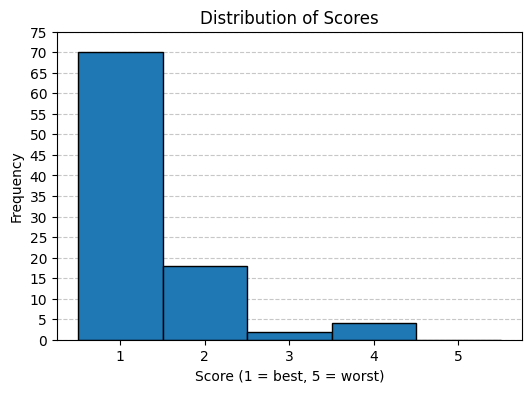

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.hist(
    scores,
    bins=[1,2,3,4,5,6],
    edgecolor='black',
    align='left'
)

plt.xticks([1,2,3,4,5])
plt.xlabel("Score (1 = best, 5 = worst)")
plt.ylabel("Frequency")
plt.title("Distribution of Scores")

# Put grid behind bars
plt.gca().set_axisbelow(True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis ticks as 5, 10, 15, ...
max_freq = plt.gca().get_ylim()[1]
plt.yticks(range(0, int(max_freq) + 5, 5))

plt.show()


In [39]:
for i, (q, s, j) in enumerate(zip(questions, scores, justifications), start=1):
    
    # Only print justification for low-quality answers
    if s in [3, 4, 5]:
        print(f"Q{i}: {q}")
        print(f"  Score: {s} (1 = best, 5 = worst)")
        print(f"  ❗ Justification: {j}\n")

Q1: What degree do you obtain when you complete the Data Science program at FAU?
  Score: 4 (1 = best, 5 = worst)
  ❗ Justification: The RAG answer incorrectly states that the degree obtained is a Master of Science (M.Sc.), whereas the gold answer specifies a Bachelor of Science (B.Sc.). This is a major factual error.

Q21: Which degree programs do these examination regulations apply to?
  Score: 4 (1 = best, 5 = worst)
  ❗ Justification: The RAG answer lists specific degree programs under the Department of Data Science but does not address the broader scope of the examination regulations applying to all Bachelor’s and Master’s programs at the Faculty of Sciences except for certain exclusions. It omits the exceptions for the Elite Master’s program Integrated Immunology and the Departments of Mathematics and Physics, which are mentioned in the gold answer.

Q24: Which academic degrees are awarded after passing the examinations?
  Score: 3 (1 = best, 5 = worst)
  ❗ Justification: The RAG